<a href="https://colab.research.google.com/github/williambrunos/PIBIC/blob/main/Semana_4/GA_PyGad_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pygad

     |████████████████████████████████| 53 kB 817 kB/s 


In [33]:
import pygad
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.special as sp
import itertools
import math

In [3]:
def ArranjoTriangular(alpha, beta, gama):
    """
    Retorna a matriz triangular A com parâmetros alpha, beta e gamma.
    complex(x, y) retorna um número complexo da forma x + yi, onde i é o número imaginário
    
    Parâmetros
    --------------------------------------
    :params alpha, beta, gama: alpha é um número real
    
    Retorno
    --------------------------------------
    :return: retorna a matriz arranjo triangular como numpy array cujos valores estão de acordo com os parâmetros recebidos
    """
    A = np.array([[0, complex(0, gama), complex(0, beta)], 
                  [complex(0, gama), 0, complex(0, alpha)], 
                  [complex(0, beta), complex(0, alpha), 0]])
    
    return A

In [4]:
def MatrizTransferenciaTriangular(A, z):
    """
    Retorna a matriz de transferência triangular T a partir de uma matriz de arranjo triangular A a partir dos passos já citados
    Erro percentual de 10^(-14) a 10^(-16), ínfimo.
    
    Parâmetros
    --------------------------------------
    :param A: matriz de Arranjo Triangular como numpy array
    :param z: número real qualquer (comprimento do acoplador)
    
    Retorno
    
    :return:  matriz numpy array de transferência triangular T calculada com erro ínfimo.
    """
    eigvals, eigvecs = la.eig(A)
    D = np.array([[eigvals[0], 0, 0], 
                  [0, eigvals[1], 0], 
                  [0, 0, eigvals[2]]])
    P = eigvecs.copy()
    E = np.array([[np.exp(z*eigvals[0]), 0, 0], 
                  [0, np.exp(z*eigvals[1]), 0], 
                  [0, 0, np.exp(z*eigvals[2])]])
    
    if np.allclose(A, P @ D @ la.inv(P), atol=1e-17):
        raise ValueError(f'Parameter Matrix A has not property A == PDP^(-1) for a tolerance of {1e-17}')
    
    # T é a matriz de transferência
    T = P @ E @ la.inv(P)
    
    return T

In [5]:
def Tv(NumberOfInputs):
    """
    Retorna uma tabela verdade (TruthTable) dado um circuito com n inputs maiores ou iguais a 1
    Checa se a variável NumberOfInputs é inteira. Se sim, continua normalmente, se não lança uma exceção com a mensagem
    'Parameter \'NumberOfInputs\' must be a integer'

    Parâmetros
    ------------------------------------------------
    :param NumberOfInputs: número de inputs do circuito lógico, deve ser um número inteiro (obrigatoriamente)
    
    Retorno
    ------------------------------------------------
    :return: Retorna a tabela verdade como uma lista do Python (caso necessário, transformar o retorno em numpy array)
    """
    if not isinstance(NumberOfInputs, int):
        raise ValueError('Parameter \'NumerOfInputs\' must be a integer')
    if NumberOfInputs < 1:                                                   
        raise ValueError('Parameter \'NumberOfInputs\' must be greater or equal to 1')
    else:
        table = list(itertools.product ([0, 1], repeat = NumberOfInputs))    
        table = np.array(table, dtype=float)
        return table

In [6]:
def PAM(TruthTable, epsilon):
    """
    Função que retorna uma modulação PAM para uma dada tabela verdade (TruthTable) e certo epsilon real arbitrário.
    Não modifica a tabela verdade original, apenas realiza alterações em uma cópia e a retorna no final.
    Funciona para qualquer tabela verdade (TruthTable) com n inputs (Matriz não precisa ser quadrada)

    Parâmetros
    ------------------------------------------------
    :param TruthTable: tabela verdade a ser analisada e transformada em modulação PAM
    :param epsilon: epsilon no qual os valores serão calculados
    
    Retorno
    ------------------------------------------------
    :return: retorna um numpy array como matriz da modulação PAM da tabela verdade recebida como parâmetro
    """
    if epsilon <= 0 or epsilon >= 1:
        raise ValueError(f'Epsilon must be major than 0 and minor than 1')
    PamTable = TruthTable.copy() # Como utiliza uma cópia, PamTable será uma matriz com elementos do tipo float
    rows, columns = PamTable.shape
    for row in range(rows):
        for column in range(columns):
            if PamTable[row][column] == 1:
                PamTable[row][column] = 1 + epsilon
            elif PamTable[row][column] == 0:
                PamTable[row][column] = 1 - epsilon
            else:
                raise ValueError('Truth Table must be filled just with zeros and ones')
    return PamTable

In [7]:
def InvPAM(PAMTable):
    """
    Função que retorna uma nova tabela verdade com modulação bniária (processo inverso da modulação PAM)
    
    Parâmetros
    ------------------------------
    :param PAMTable: Tabela verdade em modulação PAM (1 +- epsilon)
    
    Retorno
    ------------------------------
    :return: Retorna uma nova matriz como numpy array que representa a tabela verdade original (inversa da PAM)
    """
    rows, columns = PAMTable.shape
    ResultTable = np.ones(shape=(rows, columns), dtype=float)
    for row in range(rows):
        for column in range(columns):
            if PAMTable[row][column] < 1:
                ResultTable[row][column] = 0
    return ResultTable

In [8]:
def OrTruthTableGenerator(TruthTable):
    """
    Retorna uma tabela verdade do circuito lógico OR de acordo com uma tabela verdade (TruthTable). 
    Checa se a tabela está vazia, se sim a retorna (vazia), se não, realiza os cálculos.
    
    Parâmetros
    ------------------------------------------------
    :param TruthTable: tabela verdade a ser analisada
    
    Retorno
    ------------------------------------------------
    :return: Retorna a coluna (numpy array) com os valores da tabela verdade OR dos inputs da tabela verdade recebida 
    como parâmetro
    """
    rows, columns = TruthTable.shape
    ResultTable = np.zeros(shape=(rows, 1), dtype=float)
    
    if TruthTable.size == 0:
        return TruthTable
    
    for row in range(rows):
        BooleanRowArray = TruthTable[row][:]
        if np.any(BooleanRowArray):
            ResultTable[row][0] = 1
        
    return ResultTable

In [9]:

def AndTruthTableGenerator(TruthTable):
    """
    Retorna uma tabela verdade do circuito lógico AND de acordo com uma tabela verdade (TruthTable). 
    Checa se a tabela está vazia, se sim a retorna (vazia), se não, realiza os cálculos.
    
    Parâmetros
    ------------------------------------------------
    :param TruthTable: tabela verdade a ser analisada
    
    Retorno
    ------------------------------------------------
    :return: Retorna a coluna (numpy array) com os valores da tabela verdade AND dos inputs da tabela verdade recebida 
    como parâmetro
    """
    rows, columns = TruthTable.shape
    ResultTable = np.zeros(shape=(rows, 1), dtype=float)
    
    if TruthTable.size == 0:
        return TruthTable
    
    for row in range(rows):
        BooleanRowArray = TruthTable[row][:]
        if np.all(BooleanRowArray):
            ResultTable[row][0] = 1;
    
    return ResultTable

**CUIDADO**: Ao definir um novo target como numpy array, certifique-se de que o mesmo esteja como float, utilizando o atributo **dtype='float'** na construção do array.

In [10]:
solution = []
target = OrTruthTableGenerator(Tv(3))
# solution = [alpha, beta, gamma, z, epsilon]
def AptidaoArranjoTriangular(solution, solution_idx):
    A = ArranjoTriangular(solution[0], solution[1], solution[2])
    T = MatrizTransferenciaTriangular(A, solution[3])
    Inp = PAM(Tv(3), solution[4])
    Out = T @ Inp.T
    Out = Out.T
    OutPAM = PAM(target, solution[4])

    # Out1 é contraste
    Out1 = np.array([Out[:,0]])
    Out1 = Out1.T
    kernel = math.e**(-0.005*np.linalg.norm(20*np.log10(OutPAM) - 20*np.log10(abs(Out1))))

    return kernel

# Implementação do Algoritmo Genético no PyGad no nosso código

Já temos a função de aptidão, na qual depende do resultado de outras funções e retorna um valor de kernel. Nossa solução deve gerar um kernel obtido dessa função o mais próximo de 1 quanto possível, quando as relações de contraste de OutPAM e Out1 são o mais próximas possível.

Utilizaremos uma variação da função de aptidão, dada por: 

$$f(\alpha, \beta, \gamma, z, ϵ) = e^{-0.005 \; |20 \; log_{10}{OutPAM} - 20\dot log_{10}{Out1}|}$$

## Parâmetros Utilizados

fitness function : AptidaoArranjoTriangular

maximun number of generations : 500

number of parents chosen to mate : 4

parents selection type : 'sss'

crossover type : 'single_point'

mutation type : random

mutation percentage genes : 10%

## Range de valores

Os valores buscados pelo algoritmo genético são: 

$$\alpha, \beta, \gamma, z, \epsilon$$

No entanto, não pode-se encontrar quaisquer valores para estas grandezas. Portanto, restringimos inicialmente o range de valores dessas grandezas para:

- $0 \le \alpha, \beta, \gamma \le 300\$

- $0 \le z \le 1000$

- $0.35 \le \epsilon \le 0.9$

* Obs: Os valores foram definidos dessa forma pelo orientador (suscetível a mudanças)

Como pode-se observar no algoritmo, ele sempre busca o menor epsilon possível, pois pelas manipulações de matrizes realizadas na função de aptidão o kernel tende a retornar cada vez mais próximo de 1 quanto menor for a grandeza epsilon (resultados empíricos).

Por conta dessa característica do GA, tomei como hiperparâmetro o epsilon iniciando de 0.35, para que, mesmo que o GA tenda a diminuí-lo ao máximo, o valor desta grandeza não tenda a zero. O motivo? Épsilon é o parãmetro de modulação, utilizado para realizar a modulação PAM em sinais de entrada para que os cálculos sejam realizados, sendo uma representação temporária. Assim, se épsilon for pequeno demais, o sinal pode ser confundido com um ruído, o que não é interessante para os PCF's.

In [11]:
fitness_function = AptidaoArranjoTriangular

num_generations = 100
num_parents_mating = 4

sol_per_pop = 300
num_genes = 5

gene_space = [{'low': 0, 'high': 300}, {'low': 0, 'high': 300}, {'low': 0, 'high': 300}, {'low': 0, 'high': 1000}, {'low': 0.35, 'high': 0.9}]

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "scattered"

mutation_type = "random"
mutation_probability=0.01
mutation_percent_genes = 20

In [12]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=AptidaoArranjoTriangular,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       gene_space=gene_space,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes)

In [13]:
ga_instance.run()

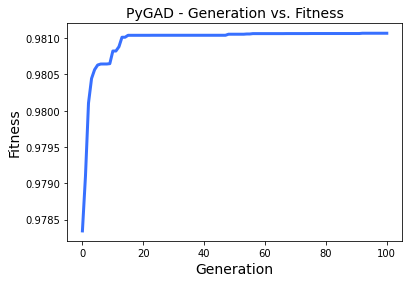

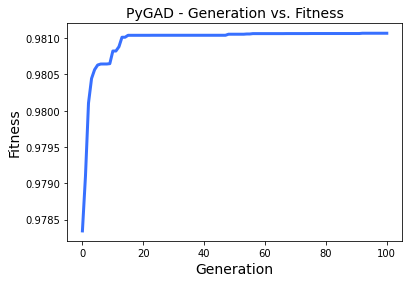

In [14]:
ga_instance.plot_fitness()

In [15]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

Parameters of the best solution : [7.14106313e+00 1.43758677e+02 1.43842546e+02 9.19014328e+02
 3.50127815e-01]
Fitness value of the best solution = 0.9810678168156811
Index of the best solution : 0


In [16]:
alpha_out, beta_out, gamma_out, z_out, epsilon_out = solution 
print(f'Alpha: {alpha_out}\nBeta: {beta_out}\nGamma: {gamma_out}\nZ: {z_out}\nEpislon: {epsilon_out}')

Alpha: 7.14106313141365
Beta: 143.75867659997184
Gamma: 143.84254628656262
Z: 919.0143278318374
Epislon: 0.3501278152068378


In [17]:
if ga_instance.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))

Best fitness value reached after 92 generations.


### Convertendo todo o processamento do GA em uma função

Por que fazer isto? Precisamos que o algoritmo genético seja executado passando como argumento apenas o target como um numpy array com dtype float, com todos os outros parâmetros sendo definidos dentro da função, pois são detalhes de implementação e arquitetura do algoritmo genético. 

In [18]:
def find_best_solutions_for_triangular_arrange(target):
  solution = []
  target = np.vstack(target)
  # solution = [alpha, beta, gamma, z, epsilon]
  def AptidaoArranjoTriangular(solution, solution_idx):
      A = ArranjoTriangular(solution[0], solution[1], solution[2])
      T = MatrizTransferenciaTriangular(A, solution[3])
      Inp = PAM(Tv(3), solution[4])
      Out = T @ Inp.T
      Out = Out.T
      OutPAM = PAM(target, solution[4])

      Out1 = np.array([Out[:,0]])
      Out1 = Out1.T
      kernel = math.e**(-0.005*np.linalg.norm(20*np.log10(OutPAM) - 20*np.log10(abs(Out1))))

      return kernel
    
  fitness_function = AptidaoArranjoTriangular

  num_generations = 100
  num_parents_mating = 4

  sol_per_pop = 300
  num_genes = 5

  gene_space = [{'low': 0, 'high': 300}, {'low': 0, 'high': 300}, {'low': 0, 'high': 300}, {'low': 0, 'high': 1000}, {'low': 0.35, 'high': 0.9}]

  parent_selection_type = "sss"
  keep_parents = 1

  crossover_type = "scattered"

  mutation_type = "random"
  mutation_probability=0.01
  mutation_percent_genes = 20

  ga_instance = pygad.GA(num_generations=num_generations,
                      num_parents_mating=num_parents_mating,
                      fitness_func=AptidaoArranjoTriangular,
                      sol_per_pop=sol_per_pop,
                      num_genes=num_genes,
                      gene_space=gene_space,
                      parent_selection_type=parent_selection_type,
                      keep_parents=keep_parents,
                      crossover_type=crossover_type,
                      mutation_type=mutation_type,
                      mutation_percent_genes=mutation_percent_genes)
    
  ga_instance.run()
  ga_instance.plot_fitness()
  solution, solution_fitness, solution_idx = ga_instance.best_solution()
  print("\n\nParameters of the best solution : {solution}".format(solution=solution))
  print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
  print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

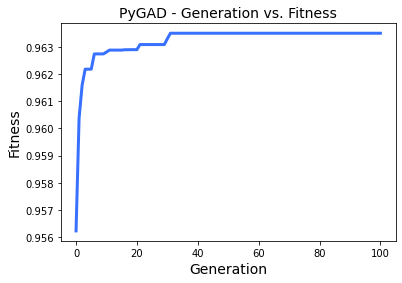



Parameters of the best solution : [1.77670101e+02 6.08203118e+01 1.55676165e+02 7.86382398e+02
 3.50133797e-01]
Fitness value of the best solution = 0.9635108601567438
Index of the best solution : 0


In [19]:
find_best_solutions_for_triangular_arrange(np.array([0, 1, 0, 1, 1, 0, 0, 1], dtype='float'))

## Melhorando nosso MVP

Até o momento, construímos funções que modelavam o arranjo triangular (ou outro, dependendo do colega da equipe) e modelamos o algoritmo genético para conseguir os melhores parâmetros das fibras ópticas tais que os arranjos de núcleos fotônicos pudessem se comportar como uma determinada porta lógica alvo (target).

No entanto, como um trabalho de um engenheiro, precisamos na verdade fazer o algoritmo genético variar os parâmetros **GEOMÉTRICOS** das fibras de forma a conseguirmos obter os tais parâmetros considerados ótimos para nosso algoritmo genético.

Em suma, conitnuaremos com nossa função de aptidão:

$$f(\alpha, \beta, \gamma, z, \epsilon) = e^{-0.005 \; |20 \; log_{10}{OutPAM} - 20\dot log_{10}{Out1}|}$$

No entanto, agora não iremos mais variar os parâmetros em si da fibra (alpha, beta etc.), mas sim os parâmetros geométricos, para que assim possamos encontrar os parâmetros ópticos por meio de modelagens matemáticas.

### Modelando Parâmetros Geométricos

#### Constante de Acoplamento

A constante de acoplamento entre dois núcleos com índice de refração $n_1$, inseridos em um meio com índice de refração $n_2$, ambos com raio $a$, com comprimento de onda $\lambda$ da luz que trespassa os mesmos e distantes um do outro de $s$ unidades, é dada por:

$$ConstanteDeAcoplamento(n_1, n_2, a, \lambda, s) = 
\frac{\sqrt{2 \; \Delta \;}\; U^3 \; K_0(W \; s/a)}{a \; V^3 \; K_1^2(W)}$$

Os parâmetros das funções acima são calculados da seguinte forma:

$$k = \frac{2 \; \pi}{\lambda}$$

$$\Delta = \frac{(n_1^2 - n_2^2)}{n_1^2}$$

$$V = k \; a \; n_1 \; \sqrt{2 \; \Delta}$$

$$U = k \; a \; \sqrt{n_1^2 - (\frac{\beta_0}{k})^2}$$

$$W = k \; a \; \sqrt{(\frac{\beta_0}{k})^2 - n_2^2}$$

**obs**: Para o cálculo das funções de Bessel, $K_0$ e $K_1$, utilizaremos o módulo scipy, com submódulo special, o qual possui a função de Bessel de segunda espécie e de ordem **n**. Aqui, precisamos apenas de ordem n=0 para $K_0$ e n=1 para $K_1$. 

Documentação: [Bessel Second Kind Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.yn.html#scipy.special.yn)

### Pensando na Solução

Podemos criar funções não tão complexas para processar todos os dados já apresentados e fazer nosso algoritmo genético variar três parâmetros geométricos ao invés de $\alpha, \beta, \gamma$, mas sim: $s_{12}, s_{13}, \theta, z, \epsilon$, sendo os dois primeiros parâmetros as distâncias entre os núcleos 1 e 3, modelando os parâmetros alpha e beta, respectivamente.

Dessa forma, o array de soluções se consolida como (importante para nossa solução em notação posicional):

$$[s_{12}, s_{13}, \theta, z, \epsilon]$$

In [20]:
# Run this cell to see the bessel second kind function documentation from scipy.special
sp.yn?

In [21]:
def ConstanteDeAcoplamento(n1, n2, a, lamb, s, Delta, U, W, V):
        """
        Retorna a constante de acoplamento da fibra entre dois núcleos de raio a
        e distantes de s unidades

        Parâmetros:
        ------------------------------------------------------------------------
        :param n1: Índice de refração dentro do núcleo
        :param n2: Índice de refração fora do núcleo
        :param a: Raio do núcleo
        :param lamb: Comprimento de onda da luz na fibra
        :param s:  Distância entre os dois núcleos

        Retorno
        ------------------------------------------------------------------------
        :return: Constante de acoplamento entre os dois núcleos
        """

        numerator = math.sqrt(2 * Delta) * math.pow(U, 3) * sp.yn(0, W * s / a)
        denominator = a * math.pow(V, 3) * (sp.yn(1, W))**2

        return numerator / denominator

In [22]:
def TerceiroLadoDoTriangulo(a, b, theta):
        """
        Retorna o terceiro lado do triângulo usando lei dos cossenos

        Parâmetros:
        ------------------------------------------------------------------------
        :param a: primeiro lado do triângulo
        :param b: segundo lado do triângulo
        :param theta: ângulo entre a e b

        Retorno
        ------------------------------------------------------------------------
        :return: terceiro lado do triângulo de acordo com a lei dos cossenos
        """

        return math.sqrt(math.pow(a, 2) + math.pow(b, 2) - 2 * a * b * math.cos(theta))

In [109]:
# Em construção...
# OBS: as subtrações dentro das raízes de U e W foram postas em módulo devido
# a erros numéricos (verificar com orientador)
def find_best_solutions_for_triangular_arrange(target, n1, n2, a, lamb, Beta_0):
  solution = []
  target = np.vstack(target)

  k = 2 * math.pi / lamb
  Delta = (math.pow(n1, 2) - math.pow(n2, 2)) / math.pow(n1, 2)
  V = k * a * n1 * math.sqrt(2 * Delta)
  U = k * a * math.sqrt(abs(math.pow(n1, 2) - math.pow((Beta_0 / k), 2)))  
  W = k * a * math.sqrt(abs(math.pow((Beta_0 / k), 2) - math.pow(n2, 2)))

  # solution = [s12, s13, theta, z, epsilon]
  def AptidaoArranjoTriangular(solution, solution_idx):
      alpha = ConstanteDeAcoplamento(n1, n2, a, lamb, solution[0], Delta, U, W, V)
      beta = ConstanteDeAcoplamento(n1, n2, a, lamb, solution[1], Delta, U, W, V)
      s23 = TerceiroLadoDoTriangulo(solution[0], solution[1], solution[2])
      gamma = ConstanteDeAcoplamento(n1, n2, a, lamb, s23, Delta, U, W, V)

      A = ArranjoTriangular(alpha, beta, gamma)
      T = MatrizTransferenciaTriangular(A, solution[3])
      Inp = PAM(Tv(3), solution[4])
      Out = T @ Inp.T
      Out = Out.T
      OutPAM = PAM(target, solution[4])

      Out1 = np.array([Out[:,0]])
      Out1 = Out1.T
      kernel = math.e**(-0.005*np.linalg.norm(20*np.log10(OutPAM) - 20*np.log10(abs(Out1))))

      return kernel
    
  fitness_function = AptidaoArranjoTriangular

  num_generations = 100
  num_parents_mating = 4

  sol_per_pop = 300
  num_genes = 5

  gene_space = [{'low': 0, 'high': 100}, {'low': 0, 'high': 100}, {'low': 0, 'high': 300}, {'low': 0, 'high': 1000}, {'low': 0.35, 'high': 0.9}]

  parent_selection_type = "sss"
  keep_parents = 1

  crossover_type = "scattered"

  mutation_type = "random"
  mutation_probability=0.01
  mutation_percent_genes = 20

  ga_instance = pygad.GA(num_generations=num_generations,
                      num_parents_mating=num_parents_mating,
                      fitness_func=AptidaoArranjoTriangular,
                      sol_per_pop=sol_per_pop,
                      num_genes=num_genes,
                      gene_space=gene_space,
                      parent_selection_type=parent_selection_type,
                      keep_parents=keep_parents,
                      crossover_type=crossover_type,
                      mutation_type=mutation_type,
                      mutation_percent_genes=mutation_percent_genes)
    
  ga_instance.run()
  ga_instance.plot_fitness()
  solution, solution_fitness, solution_idx = ga_instance.best_solution()

  # Retornando os parâmetros ao invés de fazer um print
  return solution, solution_fitness, solution_idx

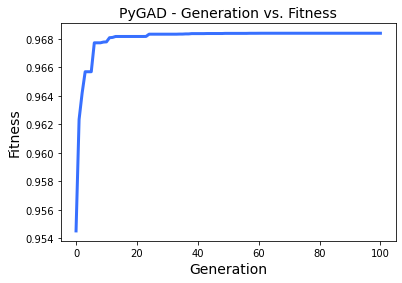

In [110]:
solution, solution_fitness, solution_idx = find_best_solutions_for_triangular_arrange(np.array([0, 0, 0, 0, 0, 0, 0, 1], dtype='float'), 
                                                                                      n1=1.02, 
                                                                                      n2=1, 
                                                                                      a=3, 
                                                                                      lamb=2, 
                                                                                      Beta_0=5)

In [111]:
# Print de valores da fibra óptica fora da função (IDEAL)
print("\n\nParameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))
s23 = math.sqrt(math.pow(solution[0], 2) + math.pow(solution[1], 2) - 2 * solution[0] * solution[1] * math.cos(solution[2]))
print('Third side of the triangle: {third_side}'.format(third_side=s23))



Parameters of the best solution : [ 45.002562    34.01644789 266.12443532 137.76790081   0.35018725]
Fitness value of the best solution = 0.9683873466519292
Index of the best solution : 0
Third side of the triangle: 71.12772497205097


In [112]:
# Célula de Teste para o parâmetro solution
triangle_first_side, triangle_second_side, triangle_angle, z, epsilon = solution
print(epsilon)

0.3501872459729081


In [113]:
def return_contrast_ratio(target, n1, n2, a, lamb, Beta_0, solution):
  """
  Dados todos os parâmetros da fibra retornados na função 
  'find_best_solutions_for_triangular_arrange', passe o parâmetro solution
  para esta função para que a mesma retorne a relação de contraste em cada linha
  da tabela verdade.

  Parâmetros:
  ------------------------------------------------------------------------------
  :param target: Array com valores lógicos alvo como um numpy array e dtype='float'
  :param n1: Índice de refração dentro do núcleo
  :param n2: Índice de refração fora do núcleo
  :param a: Raio do núcleo
  :param lamb: Comprimento de onda da luz que percorre o núcleo
  :param Beta_0: Constante de propagação da luz no núcleo
  :param solution: Melhor combinação de valores dos parâmetros do núcleo

  Retorno
  ------------------------------------------------------------------------------
  :return Out1: Retorna um numpy array de n linhas e 1 coluna com as relações de 
  contraste da fibra
  """
  triangle_first_side, triangle_second_side, triangle_angle, z, epsilon = solution
  target = np.vstack(target)

  k = 2 * math.pi / lamb
  Delta = (math.pow(n1, 2) - math.pow(n2, 2)) / math.pow(n1, 2)
  V = k * a * n1 * math.sqrt(2 * Delta)
  U = k * a * math.sqrt(abs(math.pow(n1, 2) - math.pow((Beta_0 / k), 2)))
  W = k * a * math.sqrt(abs(math.pow((Beta_0 / k), 2) - math.pow(n2, 2)))

  alpha = ConstanteDeAcoplamento(n1, n2, a, lamb, triangle_first_side, Delta, U, W, V)
  beta = ConstanteDeAcoplamento(n1, n2, a, lamb, triangle_second_side, Delta, U, W, V)
  triangle_third_side = TerceiroLadoDoTriangulo(triangle_first_side, triangle_second_side, triangle_angle)
  gamma = ConstanteDeAcoplamento(n1, n2, a, lamb, triangle_third_side, Delta, U, W, V)

  A = ArranjoTriangular(alpha, beta, gamma)
  T = MatrizTransferenciaTriangular(A, z)
  Inp = PAM(Tv(3), epsilon)
  Out = T @ Inp.T
  Out = Out.T
  OutPAM = PAM(target, epsilon)

  Out1 = np.array([Out[:,0]])
  Out1 = Out1.T

  return Out1

In [114]:
Out_test = return_contrast_ratio(np.array([0, 1, 0, 1, 1, 0, 0, 1], dtype='float'), 1.02, 1, 0.3, 2, 5, solution)
print(abs(Out_test))

[[0.6315694 ]
 [0.67588692]
 [0.63259284]
 [0.6920765 ]
 [1.30000022]
 [1.32208909]
 [1.28191635]
 [1.31228102]]


In [115]:
target = np.array([0, 1, 0, 1, 1, 0, 0, 1], dtype='float')
target = np.vstack(target)
final_array = np.concatenate((target, abs(Out_test)), axis=1)
print(final_array)

[[0.         0.6315694 ]
 [1.         0.67588692]
 [0.         0.63259284]
 [1.         0.6920765 ]
 [1.         1.30000022]
 [0.         1.32208909]
 [0.         1.28191635]
 [1.         1.31228102]]


## Plot dos Triângulos

In [116]:
triangle_first_side, triangle_second_side, angle, z, epsilon = solution
triangle_third_side = TerceiroLadoDoTriangulo(triangle_first_side, triangle_second_side, angle)

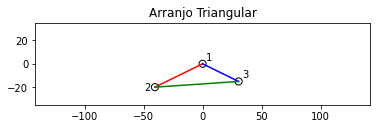

In [126]:
# s12 = 10  # e
s23 = triangle_third_side  # c
s12 = triangle_first_side  # a
s13 = triangle_second_side  # b
# s45 = 30  # d

# Raio dos núcleos
a = 3

def TeoremaDePitagoras_Altura(H,x):
    return math.sqrt(H**2 - x**2)

def find_x(s, y):
  return math.sqrt(math.pow(s, 2) - math.pow(y, 2))

def find_y(s, angle):
  return s * math.cos(angle)

Core1Coordinates = [0,0]
y_s12 = find_y(s12, angle/2)
x_s12 = find_x(s12, y_s12)
Core2Coordinates = [Core1Coordinates[0] - x_s12, 0 - y_s12]

y_s13 = find_y(s13, angle/2)
x_s13 = find_x(s13, y_s13)
Core3Coordinates = [Core1Coordinates[0] + x_s13, 0 - y_s13]

figure, axes = plt.subplots()
plt.xlim([0 - 2*(x_s12 + x_s13) , 0 + 2*(x_s12 + x_s13)])
plt.ylim([0 - (y_s12 + y_s13) , 0 + (y_s12 + y_s13)])

# -------------------- Cores -------------------------

Core1 = plt.Circle((Core1Coordinates[0], Core1Coordinates[1]), a , fill = False)
plt.text(Core1Coordinates[0] + a ,Core1Coordinates[1] + a, '1')

Core2 = plt.Circle((Core2Coordinates[0], Core2Coordinates[1]), a , fill = False)
plt.text(Core2Coordinates[0] - a * 3, Core2Coordinates[1] - a , '2')


Core3 = plt.Circle((Core3Coordinates[0], Core3Coordinates[1]), a , fill = False)
plt.text(Core3Coordinates[0] + a,Core3Coordinates[1] + a, '3')          

axes.set_aspect(1)
axes.add_artist(Core1)
axes.add_artist(Core2)
axes.add_artist(Core3)

# ------------------ Lines ----------------------
#s12
plt.plot([Core1Coordinates[0],Core2Coordinates[0]] , [Core1Coordinates[1],Core2Coordinates[1]], color='red')
#plt.text(Core1Coordinates[0]-x_s12 * 2.75 , Core1Coordinates[1] - y_s12/2 , 'a')
#s13
plt.plot([Core1Coordinates[0],Core3Coordinates[0]] , [Core1Coordinates[1],Core3Coordinates[1]], color='blue')
#plt.text((Core1Coordinates[0] + Core3Coordinates[0] * 0.53) , Core1Coordinates[1] - y_s13 / 5, 'b')
#s23
plt.plot([Core2Coordinates[0], Core3Coordinates[0]] , [Core2Coordinates[1],Core3Coordinates[1]], color='green')
#plt.text(Core2Coordinates[0] + s23 / 8 , Core2Coordinates[1] - s23 / 2 , 'c')


plt.title('Arranjo Triangular')
plt.show()

#### TODO

- Verificar o valor absoluto das subtrações de U e W (são permitidos?). ❌

- Como exportar s23 para "fora" da função de aptidão? Precisamos fazer o usuário da biblioteca ter acesso ao terceiro lado do triângulo computado numericamente para que o mesmo possa construir a fibra. ✅ (Resolvido calculando s23 a partir de solution[0], solution[1] e solution[2]).

- Conseguir uma forma de observar a relação de constraste com os dados obtidos da melhor solução do algoritmo genético. ✅ (Resolvido com a função 'check_output').